In [114]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [115]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [116]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

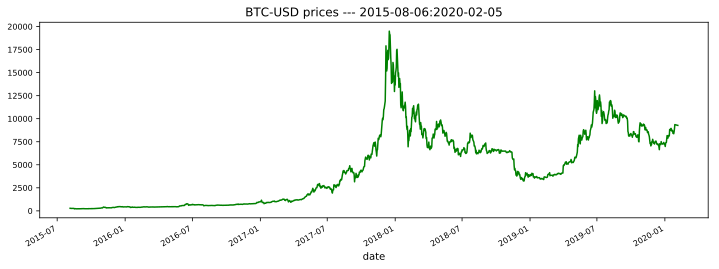

In [118]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-05', 
                  freq='daily', 
                  path='data/BTC.csv')

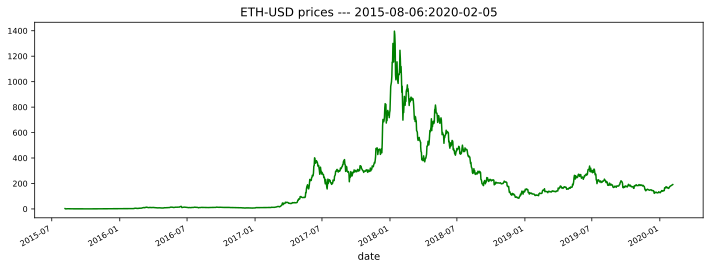

In [119]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-05', 
                  freq='daily', 
                  path='data/ETH.csv')

In [139]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

In [140]:
# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
        
COLUMNS = ['open', 'close']
    
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
    
num_assets = len(TIKERS)

# Взаимная корреляция

In [141]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH
BTC,1.000000,0.764126
ETH,0.764126,1.000000


# Построение границы эффективности

###  Задаем стартовые параметры

In [142]:
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

In [143]:
# set the number of combinations for imaginary portfolios
num_portfolios = 1
COMMISSION = 0
REBALANCE_PERIOD = 63

num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

### Определяем стартовые переменные

In [144]:
for CASH in tqdm(range(0, 19, 19)):  
                  
    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in tqdm(range(num_portfolios)):
        #weights = [1 - single_portfolio/100, single_portfolio/100]           # добавил "+1"  (учитывем еще и cash)
        weights = [0.8, 0.0]
        weights /= np.sum(weights)/(1-CASH/100)
        WEIGHTS = weights
        print(WEIGHTS)

        def initialize(context):

            context.set_commission(commission.PerDollar(cost=COMMISSION))
            context.set_slippage(InstantSlippage())
            #set_benchmark(symbol('BTC'))

            context.tikers = TIKERS
            context.assets = [context.symbol(symbol) for symbol in context.tikers]

            context.weights = WEIGHTS
            context.n_assets = len(context.assets)

            #context.window = 1

            context.rebalance_period = REBALANCE_PERIOD
            context.time = 0

        def handle_data(context, data):

            # Закупка и ребаллансировка
            if context.time == 0 or (context.time % context.rebalance_period == 0):
                
                # submit orders
                for i, asset in enumerate(context.assets):
                    order_target_percent(asset, context.weights[i])


            context.time += 1

        perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                                      end=datetime(2020, 2, 4, 0, 0, 0, 0, pytz.utc),
                                      initialize=initialize,
                                      capital_base=10000000000,
                                      handle_data=handle_data,
                                      #trading_calendar=AlwaysOpenCalendar(),
                                      data=panel)

        returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

        sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
        port_returns.append(qf.get_performance_summary(returns).annualized_returns)
        port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
        stock_weights.append(WEIGHTS)

  0%|          | 0/1 [00:00<?, ?it/s]

[1. 0.]



100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


In [145]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [146]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

,Equity(1 [BTC]),cash
2020-01-29,3.347315e+11,-290.914999
2020-01-30,3.347315e+11,-290.914999
2020-01-31,3.347315e+11,-290.914999
2020-02-03,3.347315e+11,-290.914999
2020-02-04,3.347315e+11,-290.914999


In [129]:
# Поправляем названия столбцов

#weights_df.columns = ['ETH', 'BTC', 'Cash']
weights_df.columns = ['BTC', 'Cash']
# Нормирование весов в файле

norm_weights_df = weights_df.copy()
   
#norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])    
#norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
#norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
  
norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['BTC'] + weights_df['Cash'])

norm_weights_df.head()

,BTC,Cash
2015-08-07,1.0,-3.116337e-08
2015-08-10,1.0,-3.008124e-08
2015-08-11,1.0,-3.053408e-08
2015-08-12,1.0,-3.079956e-08
2015-08-13,1.0,-3.061407e-08


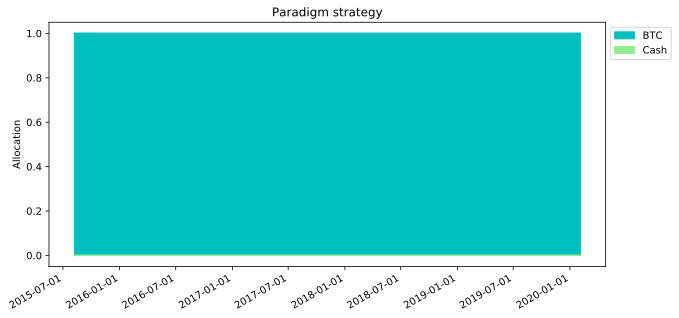

In [130]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]
plt.rcParams['figure.figsize'] = [10, 5]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

In [131]:
#df.to_csv('Cash0_BTC_ETH_100portf.csv')

In [50]:
#df = pd.read_csv('Cash0_BTC_ETH_100portf.csv', index_col=0)

In [51]:
df.tail()

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight
0,1.197096,0.726442,1.447091,1.0,0.0


In [52]:
df['Returns'] = df['Returns'] * 100
df['Volatility'] = df['Volatility'] * 100
df.head()

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight
0,119.709593,72.644209,1.447091,1.0,0.0


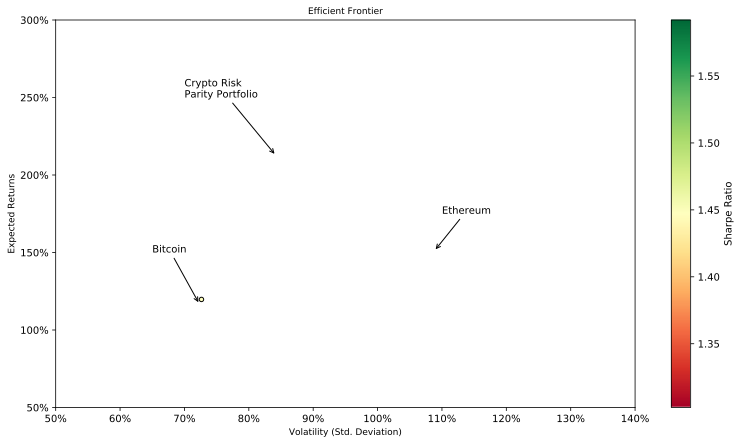

In [53]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('default')
#fig, ax = plt.subplots()
ax = df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(13, 7), grid=False)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

ax.set(xlim=(50, 140), ylim=(50, 300))

plt.annotate('Bitcoin', xy=(72.312216, 116.818904), xytext=(65, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(108.826239, 151.058583), xytext=(110, 175),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk\nParity Portfolio', xy=(84.180013, 212.693054), xytext=(70, 250),
             arrowprops=dict(arrowstyle="->"))

plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

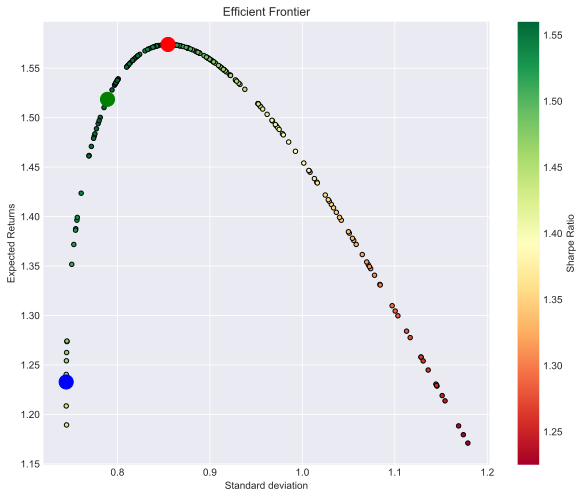

In [14]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_portfolio = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_portfolio['Volatility'], y=max_return_portfolio['Returns'], c='red', marker='o', s=200 )

#plt.annotate('Max sharpe', xy=(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns']), xytext=(0.2, 1.1), 
             #arrowprops=dict(facecolor='black', shrink=0.01))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [42]:
good_sharpe_portfolios = df.loc[df['Sharpe Ratio'] > 1.85]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Returns'] > 2.158]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Volatility'] < 0.74]
#good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['BTC Weight'] > 0.45]
good_sharpe_portfolios['Cash'] = 1 - good_sharpe_portfolios['BTC Weight'] - good_sharpe_portfolios['ETH Weight']
good_sharpe_portfolios

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight,Cash
4835,2.159399,0.739913,1.914645,0.410920,0.339080,0.25
5053,2.158079,0.739626,1.914090,0.394035,0.345965,0.26


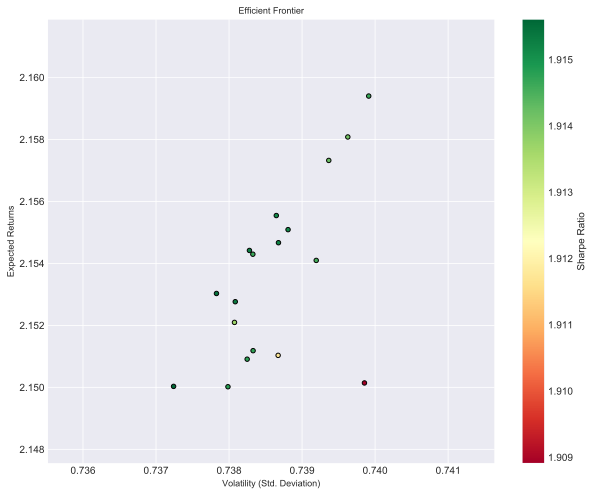

In [41]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
good_sharpe_portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

In [15]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)
print(max_return_portfolio.T)

                   141
Returns       1.232769
Volatility    0.744547
Sharpe Ratio  1.450341
BTC Weight    0.976062
ETH Weight    0.023938
                    37
Returns       1.518573
Volatility    0.789275
Sharpe Ratio  1.560030
BTC Weight    0.758406
ETH Weight    0.241594
                   167
Returns       1.574020
Volatility    0.854742
Sharpe Ratio  1.524471
BTC Weight    0.581100
ETH Weight    0.418900
